In [1]:
from brian2 import *
prefs.codegen.target = 'numpy'

In [2]:
%matplotlib inline
# Change the default figure size
plt.rcParams['figure.figsize'] = (10, 5)
%xmode minimal

Exception reporting mode: Minimal


## Exercise 1

We model a single neuron with a noisy membrane potential as in the tutorial. Note that the model written below switched off the noise by setting its standard deviation (`sigma_noise`) to 0.

In [3]:
start_scope()
E_L = -70*mV
V_threshold = -50*mV
C = 100*pF
g_L = 10*nS
tau = C/g_L
I_ext = 0.21*nA       # TODO: change to 0.15*nA for question 1, see below
sigma_noise = 0.*mV   # TODO: change to get ~33 spikes, see question 1 below
neurons = NeuronGroup(1, 'dV/dt = (g_L*(E_L-V) + I_ext)/C + sigma_noise*xi*tau**-0.5: volt',
                      threshold='V>V_threshold', reset='V=E_L', method='euler')
# Initialize values
neurons.V = 'rand()*10*mV + E_L'

# record membrane potential and spikes
v_mon = StateMonitor(neurons, 'V', record=True)
spike_mon = SpikeMonitor(neurons)

# run simulation
run(1*second)

Number of spikes:  33


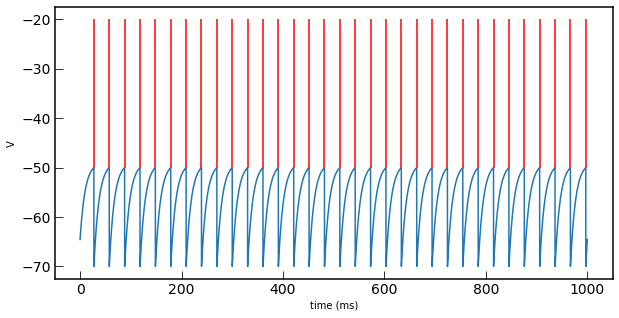

In [4]:
fig, ax = plt.subplots()
ax.plot(v_mon.t/ms, v_mon.V[0]/mV)
ax.vlines(spike_mon.t/ms, V_threshold/mV, -20., color='r')
ax.set(xlabel='time (ms)', ylabel='V')
print('Number of spikes: ', spike_mon.count[0])

### Question 1:
In the above code, change the value of the external current `I_ext` to `0.15*nA`, and increase the value for `sigma_noise` so that the neuron generates roughly as many spikes as before (i.e., when `I_ext=0.21*nA` and `sigma_noise=0*mV`).

**Solution**: With `I_ext = 0.15*nA`, a value of slightly below 10mV for `sigma_noise` (`~9.65*mV`) will give 33 spikes.

In [5]:
start_scope()
E_L = -70*mV
V_threshold = -50*mV
C = 100*pF
g_L = 10*nS
I_ext = 0.15*nA       # TODO: change to 0.15*nA for question 1, see below
sigma_noise = 9.65*mV   # TODO: change to get ~33 spikes, see question 1 below
neurons = NeuronGroup(1, 'dV/dt = (g_L*(E_L-V) + I_ext)/C + sigma_noise*xi*tau**-0.5: volt',
                      threshold='V>V_threshold', reset='V=E_L', method='euler')
# Initialize values
neurons.V = 'rand()*10*mV + E_L'

# record membrane potential and spikes
v_mon = StateMonitor(neurons, 'V', record=True)
spike_mon = SpikeMonitor(neurons)

# run simulation
run(1*second)

Number of spikes:  35


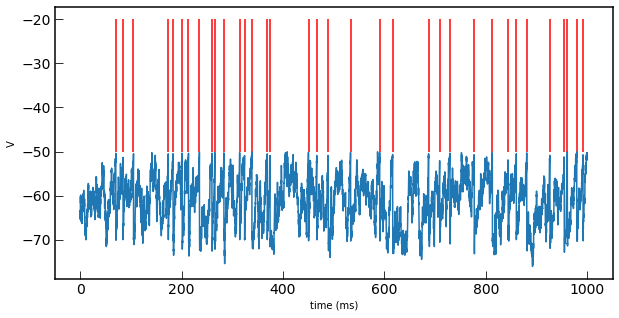

In [6]:
fig, ax = plt.subplots()
ax.plot(v_mon.t/ms, v_mon.V[0]/mV)
ax.vlines(spike_mon.t/ms, V_threshold/mV, -20., color='r')
ax.set(xlabel='time (ms)', ylabel='V')
print('Number of spikes: ', spike_mon.count[0])

### Question 2:
How do the generated spike trains differ between the simulations with and without noise? How could you quantify this difference (*hint*: have a look at lecture 3)? Note: just reply how you *would* quantify it, no need to actually do it. 

**Answer**: The spikes no longer occur at regular intervals. The **coefficient of variation (CV)** can be used to quantify this difference.

## Exercise 2

The following network has three neurons that connect to each other in a circular fashion, i.e. neuron 0 connects to neuron 1, neuron 1 connects to neuron 2, and neuron 2 connects back to neuron 0. Only the first neuron receives a direct current stimulation.

```
    +
    |
    | external stimulus
    |
    v
+---+-+
|     +----------+
|  0  |          |
+--+--+          |
   ^             v
   |          +--+--+
   |          |     |
+--+--+       |  1  |
|     |       +-----+
|  2  +<---------+
+-----+
```

In [12]:
start_scope()
tau = 10*ms
sigma_noise = 10*mV
theta_stim = 0.; sigma_stim = pi/8; amp_stim = 0.4*nA  # stimulus parameters
tau_e = 10*ms
N_E = 400

# excitatory neurons
neurons = NeuronGroup(N_E, '''dV/dt = (g_L*(E_L-V) + I_stim + I_syn)/C: volt
                                  dI_syn/dt = -I_syn/tau_e : amp
                                  I_stim : amp (constant)''',
                      threshold='V>V_threshold', reset='V=E_L', method='euler')
neurons.V = 'E_L + 10*mV*rand()'
neurons.I_stim[0] = 0.25*nA # we only set a current for the first neuron

# Synapses
w = 0.3*nA
connections = Synapses(neurons, neurons, on_pre='I_syn += w')
# This means: connect 0->1, 1->2, 2->0
connections.connect(i=[0, 1, 2], j=[1, 2, 0])

state_mon = StateMonitor(neurons, ['V', 'I_syn'], record=True)
run(1*second)

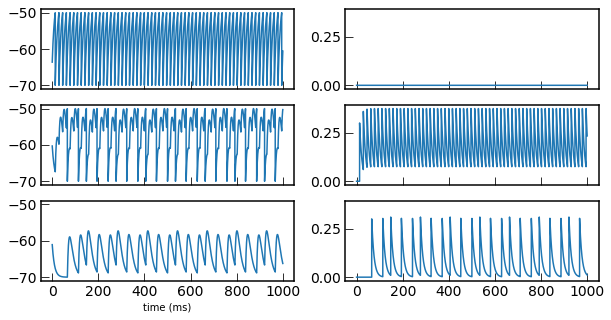

In [13]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey='col')
ax[0, 0].plot(state_mon.t/ms, state_mon.V[0]/mV)
ax[1, 0].plot(state_mon.t/ms, state_mon.V[1]/mV)
ax[2, 0].plot(state_mon.t/ms, state_mon.V[2]/mV)
ax[0, 1].plot(state_mon.t/ms, state_mon.I_syn[0]/nA)
ax[1, 1].plot(state_mon.t/ms, state_mon.I_syn[1]/nA)
ax[2, 1].plot(state_mon.t/ms, state_mon.I_syn[2]/nA)
ax[2, 0].set(xlabel='time (ms)');

### Question 3
Describe the above plot: what is plotted in the three subplots and why do you see the respective patterns?

**Solution**: Each of the plots on the left shows the membrane potential over time of each neuron. The first neuron spikes regularly due to its input current. Each of its spikes excites the second neuron, and several of these spikes are enough to push the neuron over its threshold. It therefore also spikes regularly, but with a lower rate. The third neuron receives the low-rate input from the second neuron, but this input is too sparse to make the neuron spike. The plots on the right show the synaptic current in each cell. It is always zero for the first neuron, since it does not receive any spikes from the last neuron.

## Question 4

If you change the value of the synaptic strength `w` in the above code to `0.35*nA`, strange things happen. Can you explain what is going on?

**Solution** The stimulation of the third neuron is now strong enough for this neuron to cross its threshold. It will therefore emit spikes and stimulate the first neuron. This makes the neuron emit more spikes, which excites the second neuron even more, and so on. The circuit has become a feedback loop and activity "explodes".

In [14]:
start_scope()
tau = 10*ms
sigma_noise = 10*mV
theta_stim = 0.; sigma_stim = pi/8; amp_stim = 0.4*nA  # stimulus parameters
tau_e = 10*ms
N_E = 400

# excitatory neurons
neurons = NeuronGroup(N_E, '''dV/dt = (g_L*(E_L-V) + I_stim + I_syn)/C: volt
                                  dI_syn/dt = -I_syn/tau_e : amp
                                  I_stim : amp (constant)''',
                      threshold='V>V_threshold', reset='V=E_L', method='euler')
neurons.V = 'E_L + 10*mV*rand()'
neurons.I_stim[0] = 0.25*nA # we only set a current for the first neuron

# Synapses
w = 0.35*nA
connections = Synapses(neurons, neurons, on_pre='I_syn += w')
# This means: connect 0->1, 1->2, 2->0
connections.connect(i=[0, 1, 2], j=[1, 2, 0])

state_mon = StateMonitor(neurons, ['V', 'I_syn'], record=True)
run(1*second)

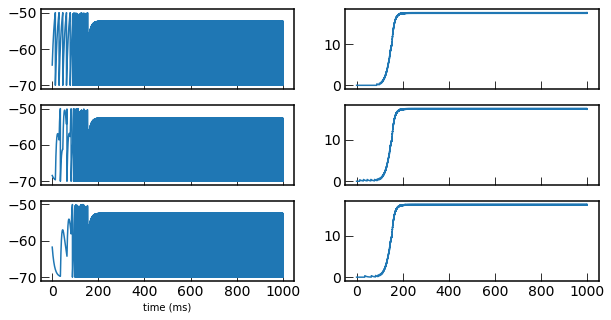

In [15]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey='col')
ax[0, 0].plot(state_mon.t/ms, state_mon.V[0]/mV)
ax[1, 0].plot(state_mon.t/ms, state_mon.V[1]/mV)
ax[2, 0].plot(state_mon.t/ms, state_mon.V[2]/mV)
ax[0, 1].plot(state_mon.t/ms, state_mon.I_syn[0]/nA)
ax[1, 1].plot(state_mon.t/ms, state_mon.I_syn[1]/nA)
ax[2, 1].plot(state_mon.t/ms, state_mon.I_syn[2]/nA)
ax[2, 0].set(xlabel='time (ms)');

## The End